# Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, ResNet152V2, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import matplotlib as plt
import zipfile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

# Specify the path to your zip file
zip_path = '/content/drive/MyDrive/Final_VGG16_Individual/SkinDiseases.zip'
extract_path = '/content/SkinDiseases'
# Open and extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")

Extraction completed!


#  Data Loading

In [4]:
data_dir_train="/content/SkinDiseases/SkinDisease/train"
data_dir_test="/content/SkinDiseases/SkinDisease/test"

In [5]:
train_data=tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    batch_size=64,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
)

Found 13898 files belonging to 22 classes.


In [6]:
class_names = train_data.class_names
class_names

['Acne',
 'Actinic_Keratosis',
 'Benign_tumors',
 'Bullous',
 'Candidiasis',
 'DrugEruption',
 'Eczema',
 'Infestations_Bites',
 'Lichen',
 'Lupus',
 'Moles',
 'Psoriasis',
 'Rosacea',
 'Seborrh_Keratoses',
 'SkinCancer',
 'Sun_Sunlight_Damage',
 'Tinea',
 'Unknown_Normal',
 'Vascular_Tumors',
 'Vasculitis',
 'Vitiligo',
 'Warts']

In [7]:
test_data=tf.keras.utils.image_dataset_from_directory(data_dir_test)

Found 1546 files belonging to 22 classes.


In [8]:
train_data_itr=train_data.as_numpy_iterator()
batch=train_data_itr.next()
print(len(batch))
print(batch[0].shape)
print(batch[1])

2
(64, 256, 256, 3)
[ 7  2 17 15 15 11  2 20 21  4 16  2 11 21 19 17  2 11 14  6  7  8 17 20
 14  2  2 17 16 20  6  1 19 15 20  6 10  6 16 14 13 18  5  6 10 17 20 14
 16 19  8 17 16  6 17 20  2 17 10 14  1 11  8 20]


# Data Visualization

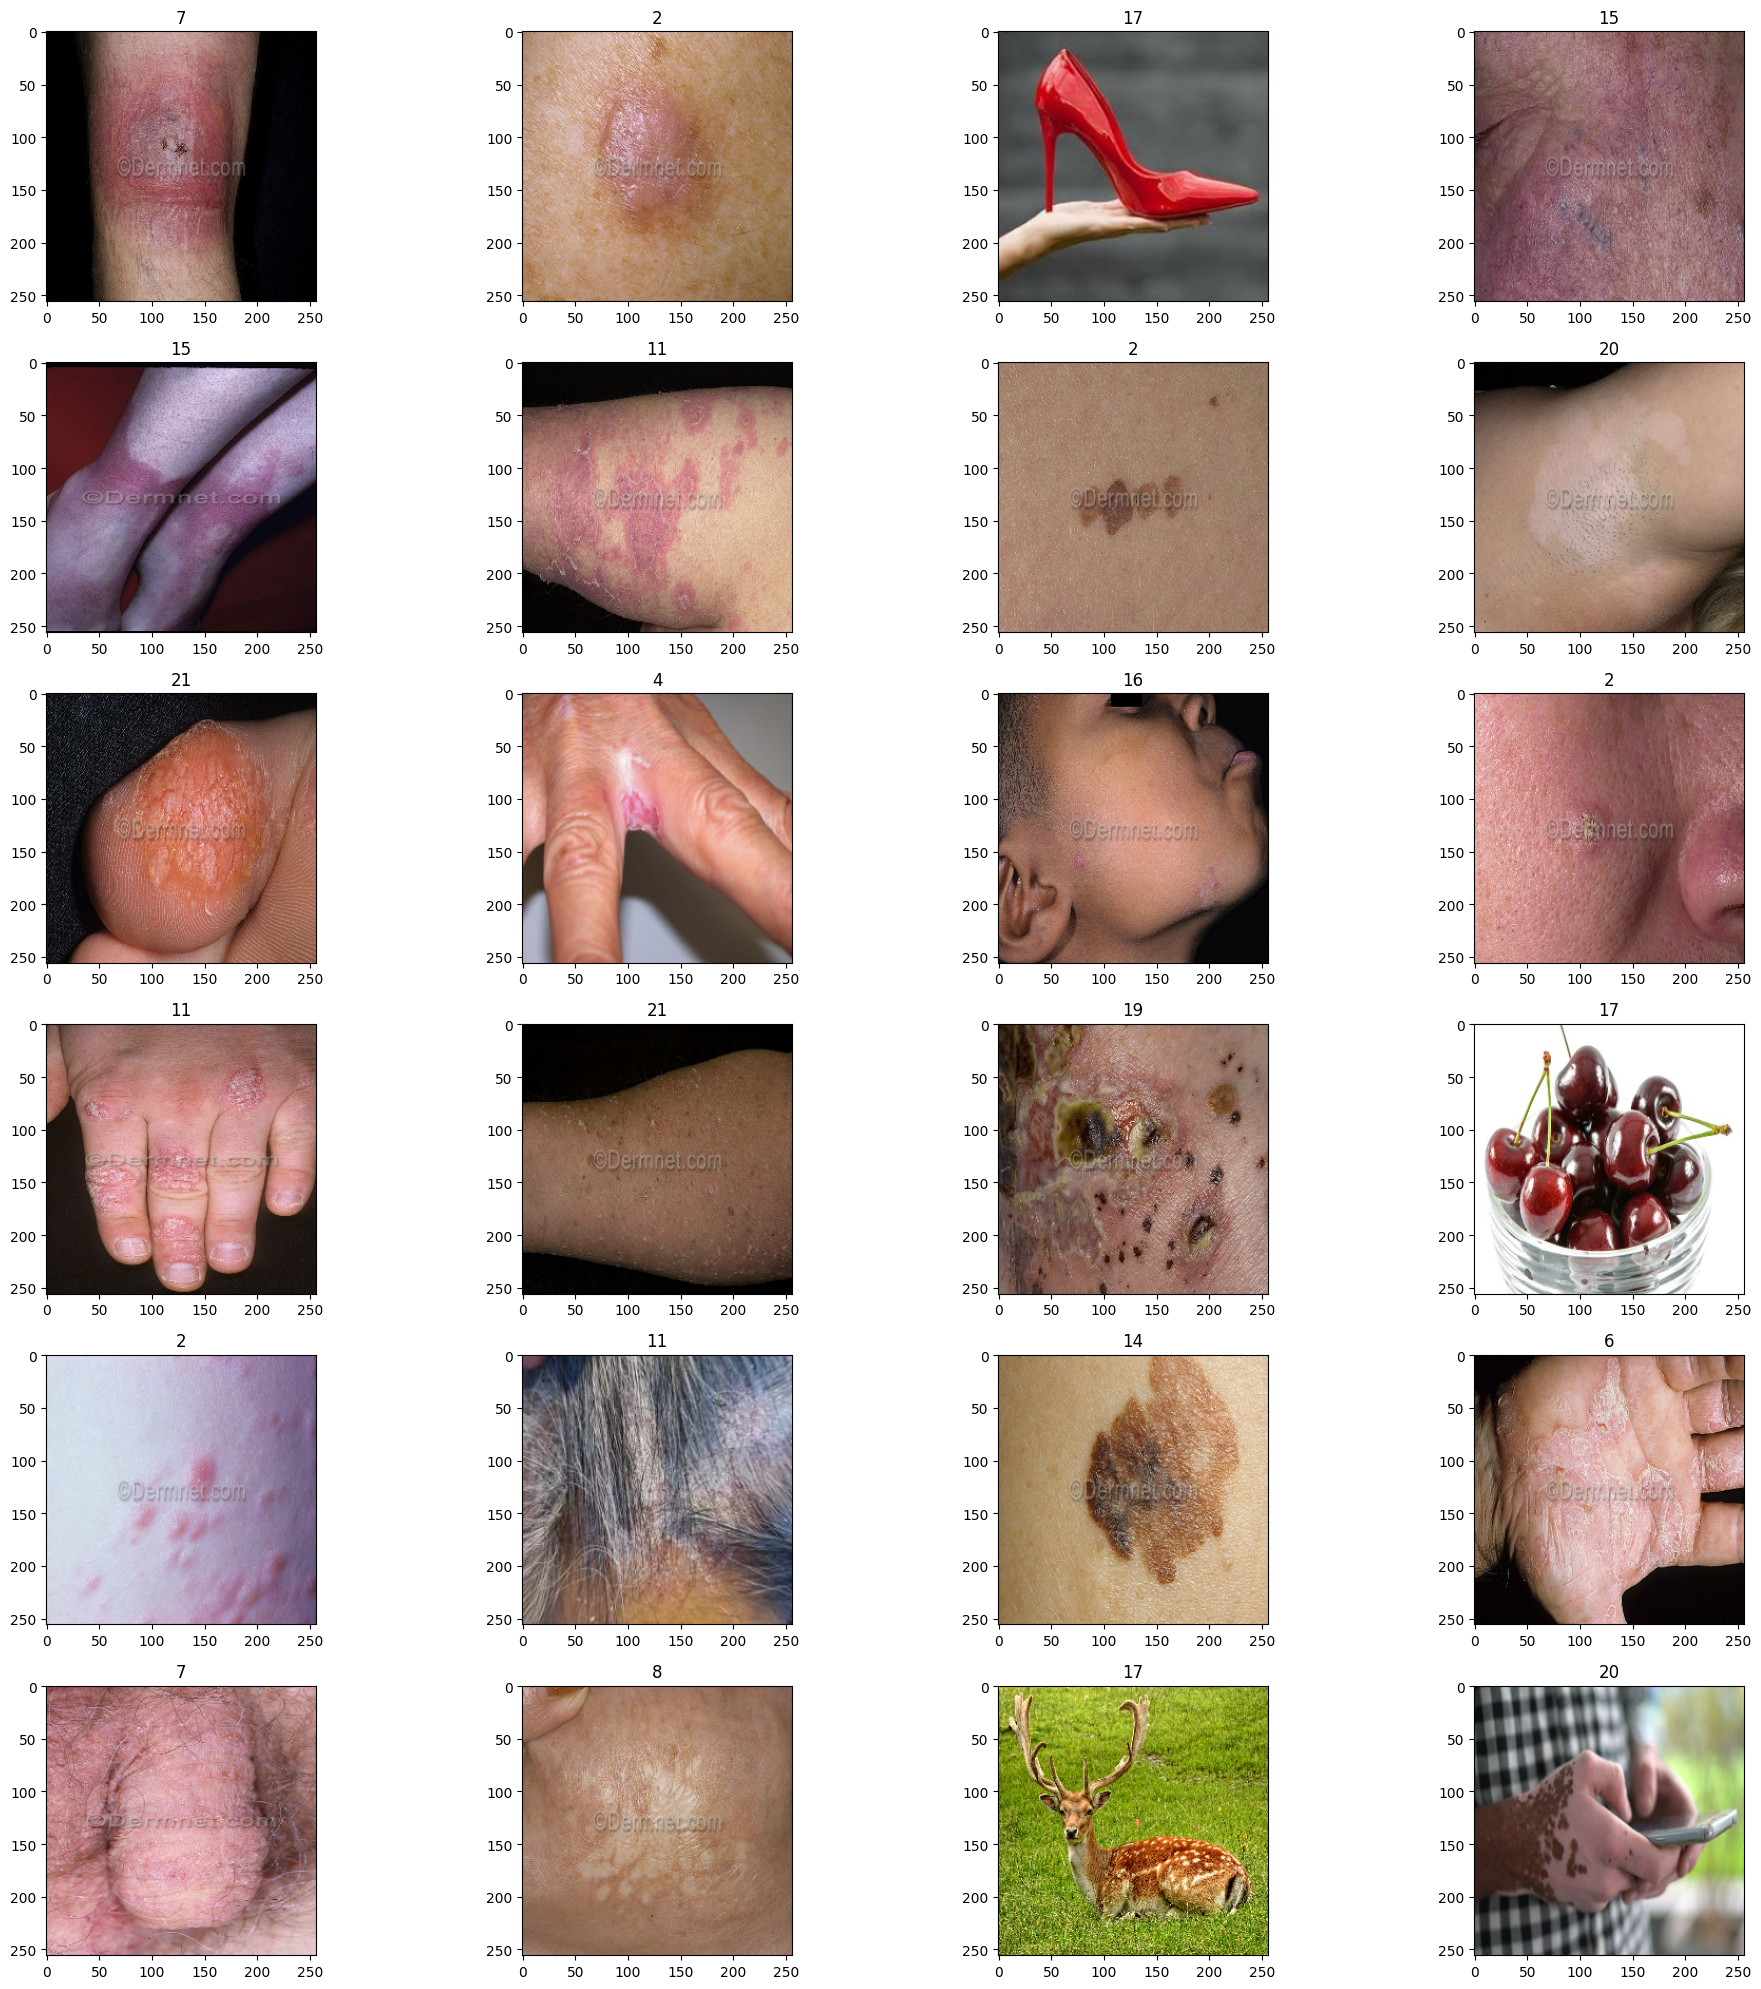

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))

for idx, img in enumerate(batch[0][:24]):
    row = idx // 4
    col = idx % 4
    ax[row, col].imshow(img.astype(int))
    ax[row, col].title.set_text(str(batch[1][idx]))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Data Prepration

In [10]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [12]:
# Parameters
batch_size = 64
input_shape = (128, 128, 3)
num_classes = 22
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

Found 13898 images belonging to 22 classes.


In [13]:
test_generator = test_datagen.flow_from_directory(
    data_dir_test,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1546 images belonging to 22 classes.


# Model Training

In [14]:
#new try
# Unified input for all three models
input_tensor = Input(shape=input_shape, name='input_tensor')


In [15]:
# Branch 1: InceptionV3
from tensorflow.keras.applications import InceptionV3, ResNet152V2, VGG16
inception = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor, name='InceptionV3')
for layer in inception.layers:
    layer.trainable = False
inception_output = GlobalAveragePooling2D(name='inception_gavgpool')(inception.output)
inception_output = Dense(512, activation='relu', name='inception_dense')(inception_output)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# Branch 2: ResNet152V2
res_net = ResNet152V2(include_top=False, weights=None, input_tensor=input_tensor, name='ResNet152V2')
for layer in res_net.layers[:140]:
    layer.trainable = False
res_net_output = GlobalAveragePooling2D(name='resnet_gavgpool')(res_net.output)
res_net_output = Dense(512, activation='relu', name='resnet_dense')(res_net_output)


In [17]:
# Branch 3: VGG16
vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor, name='VGG16')
for layer in vgg.layers:
    layer.trainable = False
vgg_output = GlobalAveragePooling2D(name='vgg_gavgpool')(vgg.output)
vgg_output = Dense(512, activation='relu', name='vgg_dense')(vgg_output)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [31]:
# Reshape outputs to match expected shapes before concatenation
inception_output = tf.reshape(inception_output, (tf.shape(inception_output)[0], 128, 128, 3))
res_net_output = tf.reshape(res_net_output, (tf.shape(res_net_output)[0], 128, 128, 3))
vgg_output = tf.reshape(vgg_output, (tf.shape(vgg_output)[0], 128, 128, 3))

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [18]:
# Concatenate outputs
concatenated = Concatenate(name='concat_features')([inception_output, res_net_output, vgg_output])


In [19]:
# Fully connected layers
x = Dense(128, activation='relu', name='fc_128')(concatenated)
x = Dropout(0.2, name='dropout_128')(x)
x = Dense(32, activation='relu', name='fc_32')(x)
x = Dropout(0.2, name='dropout_32')(x)
output = Dense(num_classes, activation='softmax', name='output_softmax')(x)


In [20]:
# Fusion model
fusion_model = Model(inputs=input_tensor, outputs=output)


In [23]:
# Compile the model
fusion_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
# Summary of the model
fusion_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_tensor (InputLayer) │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_tensor[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 32, 32, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 32, 32, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 34, 34, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 97,411,542 (371.60 MB)

 Trainable params: 56,933,750 (217.19 MB)

 Non-trainable params: 40,477,792 (154.41 MB)

In [21]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot as plt
from numpy import expand_dims

In [26]:
# Load and preprocess image
img_path = '/content/SkinDiseases/SkinDisease/test/Acne/157__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpeg'  # Replace with your image file
img = load_img(img_path, target_size=(224, 224))  # Load and resize image
img = img_to_array(img)
img = expand_dims(img, axis=0)
img = preprocess_input(img)  #

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Shape of extracted features: (1, 1536)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


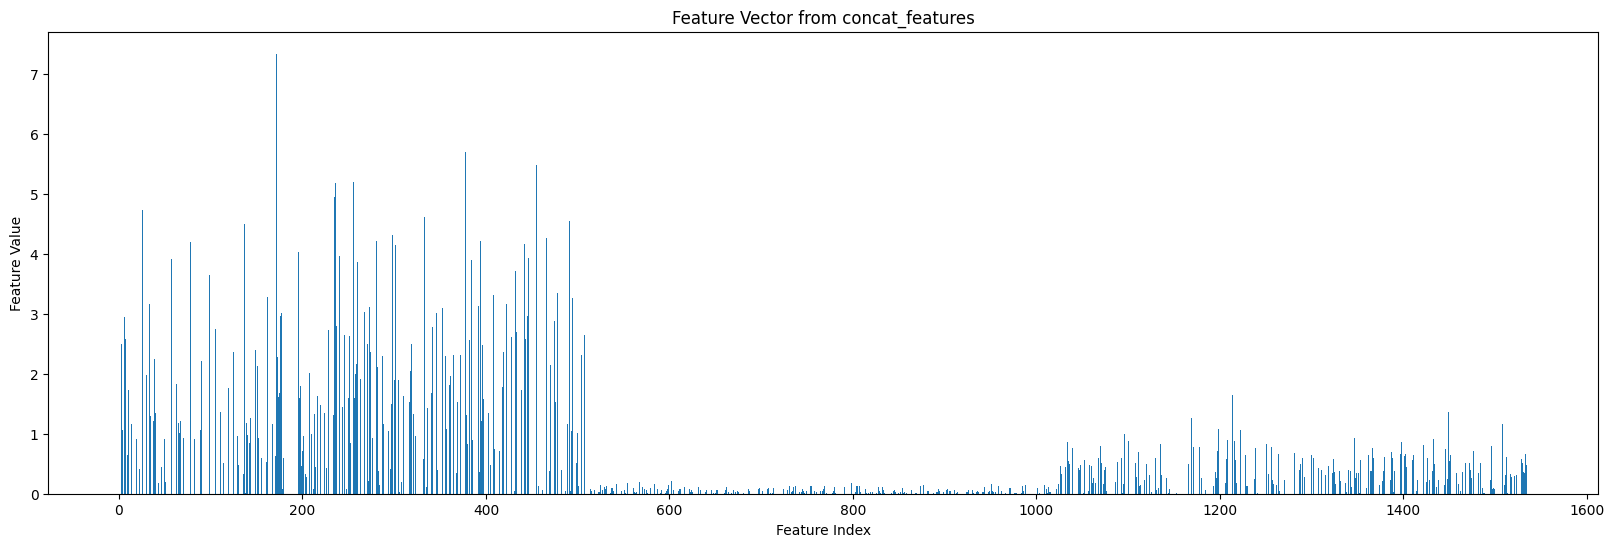

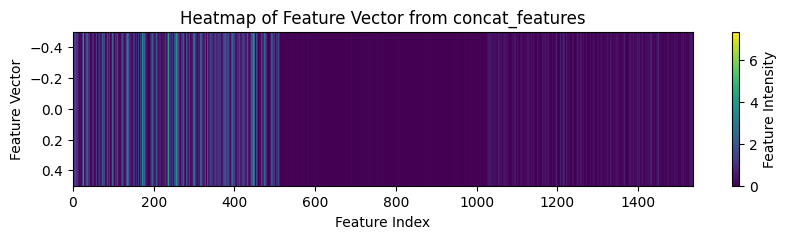

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input  # Modify preprocessing if required
from matplotlib import pyplot
import numpy as np

# Create a model to output features from the "concat_features" layer
feature_extractor = Model(inputs=fusion_model.input, outputs=fusion_model.get_layer('concat_features').output)

# Load and preprocess the image
img_path = '/content/SkinDiseases/SkinDisease/test/Acne/157__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpeg'  # Replace with your image path
img = load_img(img_path, target_size=input_shape[:2])  # Resize image to match model input size
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch size
img_array = img_array / 255.0  # Normalize image if required (already scaled in your generator)

# Extract features
features = feature_extractor.predict(img_array)

# Display the extracted features
print("Shape of extracted features:", features.shape)

# Visualize the features as a grid of images
num_features = features.shape[-1]  # Number of feature maps
square = int(np.ceil(np.sqrt(num_features)))  # Determine the grid size for visualization

import matplotlib.pyplot as plt

# Extract features from the concatenation layer
features = feature_extractor.predict(img_array)

# Flattened feature vector
features = features[0]  # Remove the batch dimension (shape: 1536,)

# Visualize as a bar plot
plt.figure(figsize=(20, 6))
plt.bar(range(len(features)), features)
plt.title('Feature Vector from concat_features')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()

# Alternatively, visualize as a heatmap
plt.figure(figsize=(10, 2))
plt.imshow(features.reshape(1, -1), aspect='auto', cmap='viridis')
plt.colorbar(label='Feature Intensity')
plt.title('Heatmap of Feature Vector from concat_features')
plt.xlabel('Feature Index')
plt.ylabel('Feature Vector')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


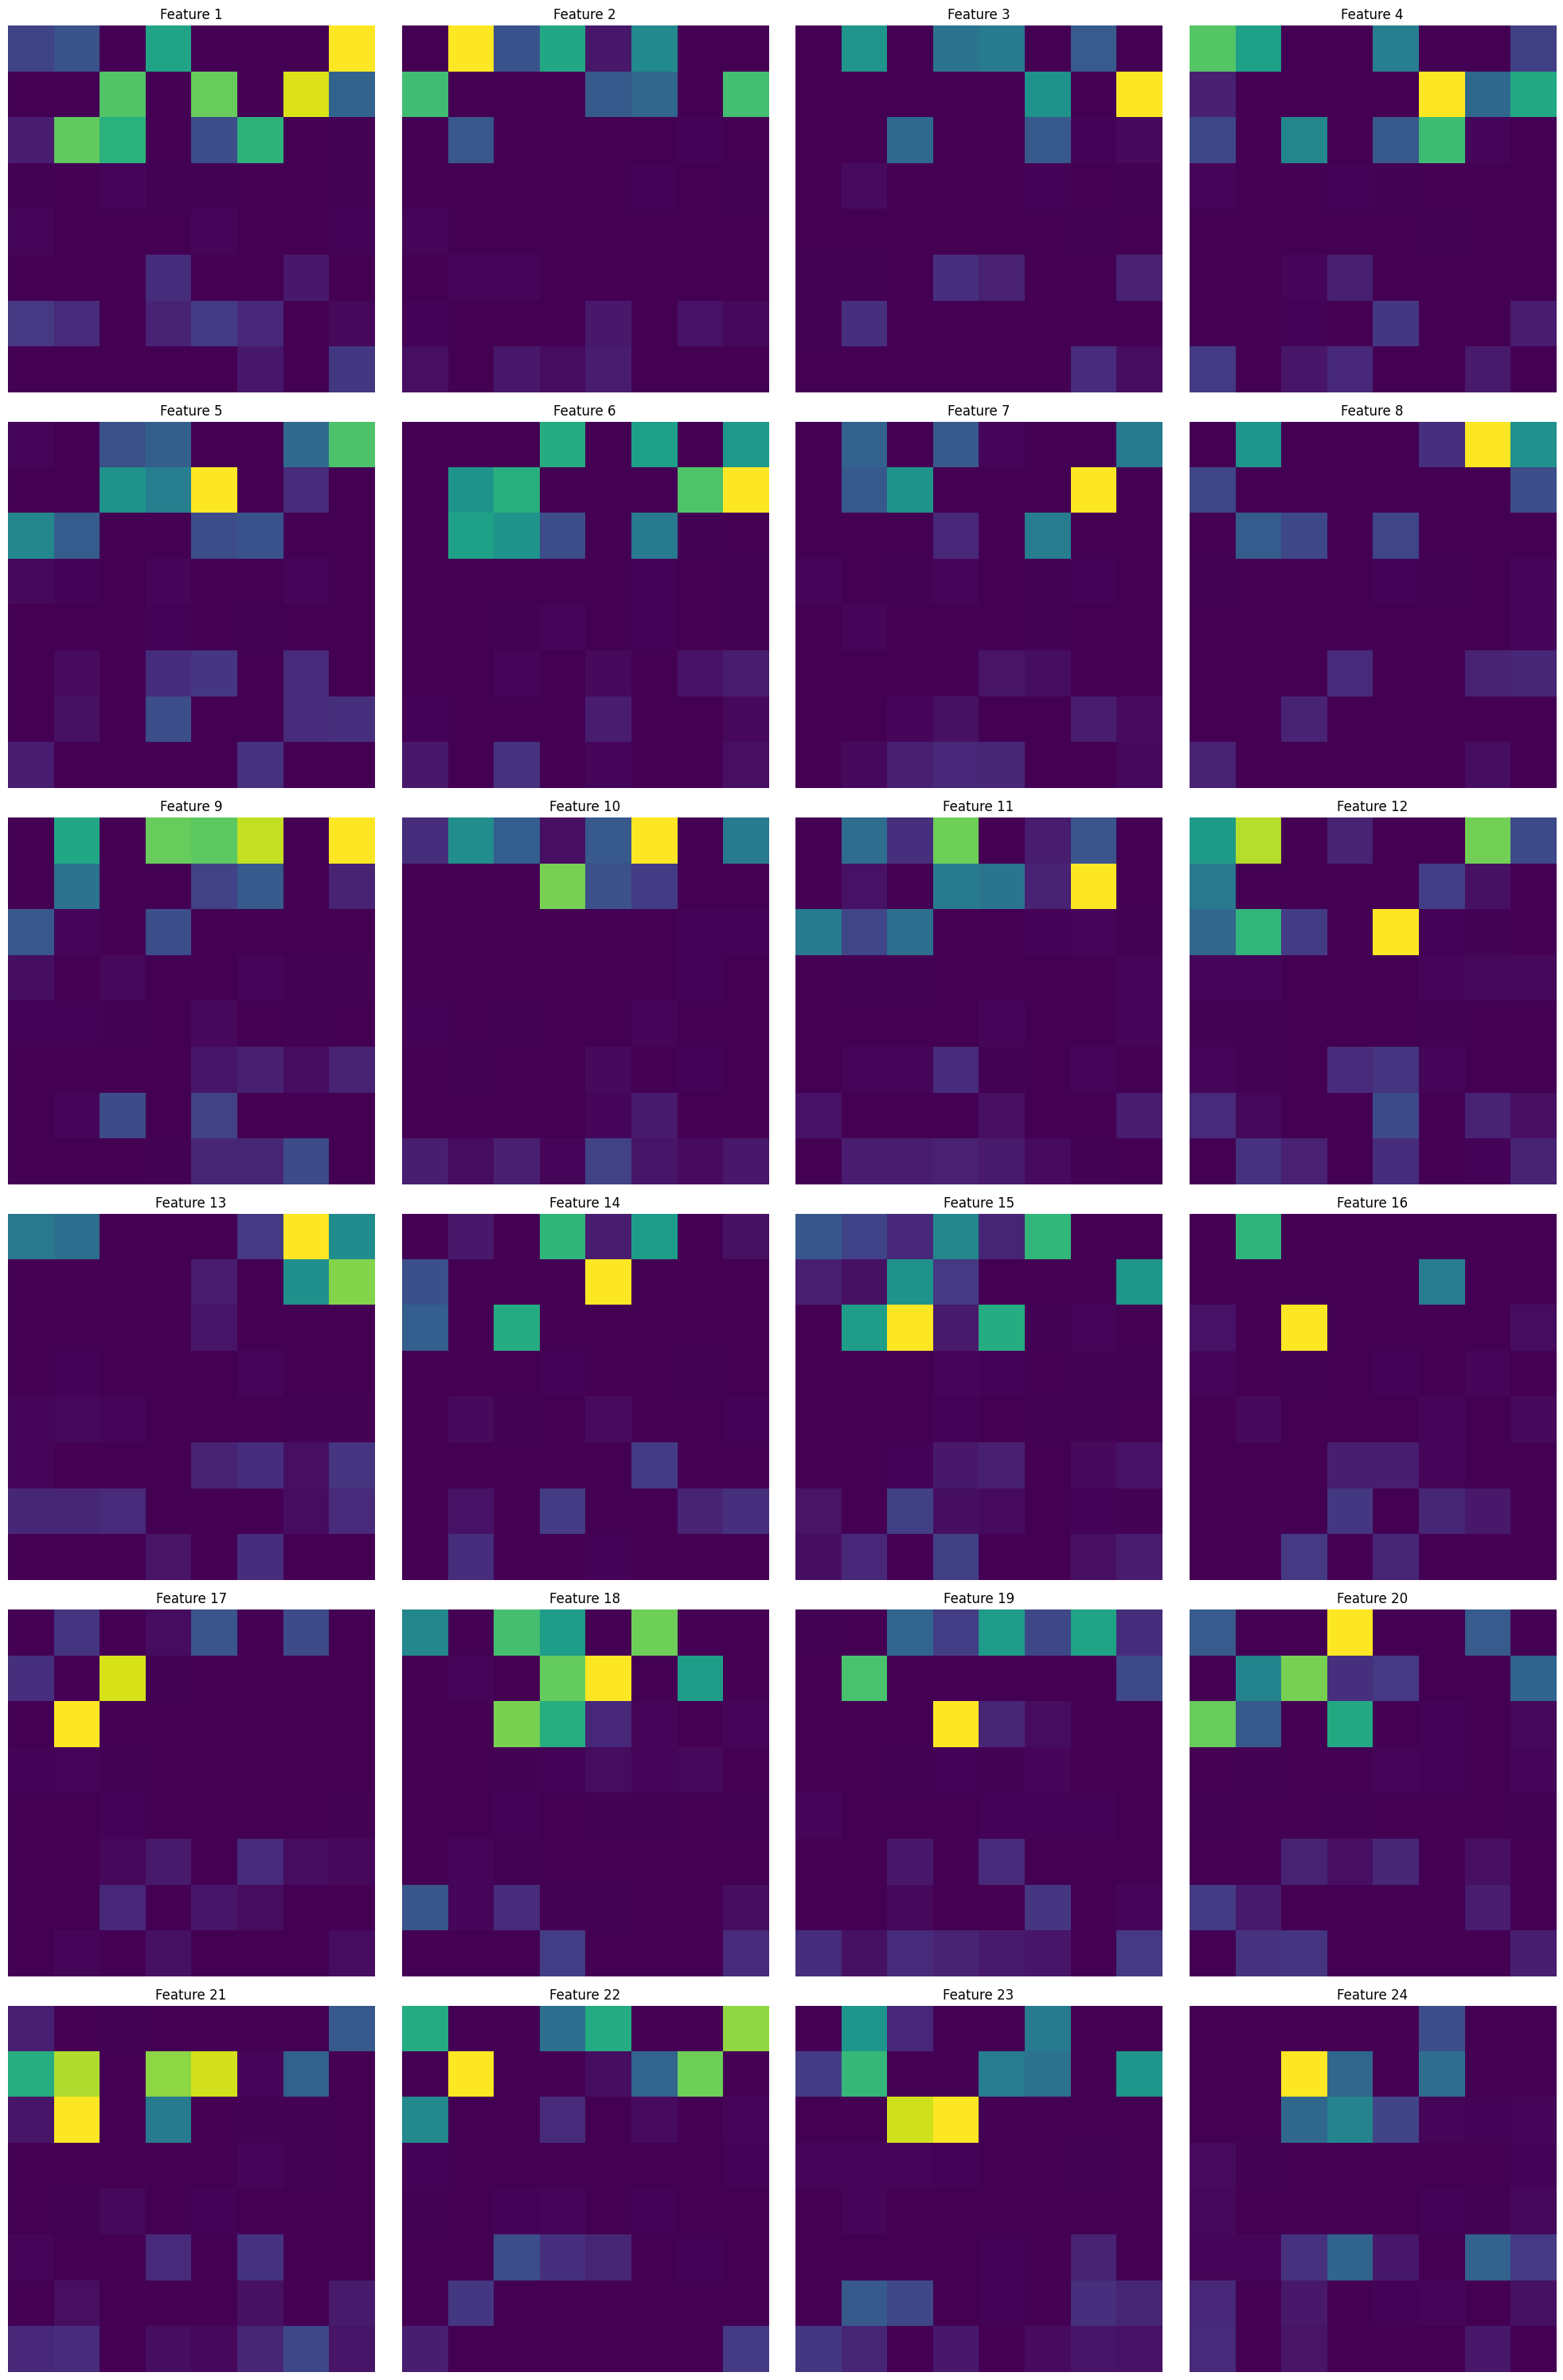

In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained fusion model
model = fusion_model  # Your model with the concatenation layer
layer_name = "concat_features"  # The name of the concatenation layer

# Create a model to extract features from the `concat_features` layer
feature_model = tf.keras.models.Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)

# Load and preprocess an image
img_path = '/content/SkinDiseases/SkinDisease/test/Acne/acne-cystic-1.jpeg'  # Replace with the path to your image
img = load_img(img_path, target_size=(128, 128))  # Match the input size of your model
img_array = img_to_array(img) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Get features from the concatenation layer
features = feature_model.predict(img_array)[0]  # Remove batch dimension (shape: [1536])

# Reshape the features to match the original spatial dimensions
feature_shape = (8, 8, -1)  # Adjust according to your model's original spatial dimensions
reshaped_features = features.reshape(feature_shape)

# Visualize the extracted features with spatial information
num_features = reshaped_features.shape[-1]
num_cols = 4  # Number of columns in the grid
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate number of rows required

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
for i in range(num_features):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(reshaped_features[:, :, i], cmap='viridis')  # Display each feature map
    ax.set_title(f'Feature {i + 1}')
    ax.axis('off')

# Hide any empty subplots if the number of features is not perfectly divisible by the number of columns
for j in range(num_features, num_rows * num_cols):
    fig.delaxes(axes[j // num_cols, j % num_cols])

plt.tight_layout()
plt.show()


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath=f"/content/drive/My Drive/files/fusion_model.keras",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=1e-5,verbose=1)

In [ ]:
# Training the model
history = fusion_model.fit(
    train_generator,
    epochs=30,
    callbacks=[reduce_lr],
    validation_data=test_generator
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 445s 1s/step - accuracy: 0.0855 - loss: 3.1194 - val_accuracy: 0.2193 - val_loss: 2.6571 - learning_rate: 0.0010
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 200s 826ms/step - accuracy: 0.2091 - loss: 2.6642 - val_accuracy: 0.2859 - val_loss: 2.4490 - learning_rate: 0.0010
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 179s 803ms/step - accuracy: 0.2575 - loss: 2.4876 - val_accuracy: 0.3066 - val_loss: 2.3287 - learning_rate: 0.0010
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 182s 808ms/step - accuracy: 0.2839 - loss: 2.4049 - val_accuracy: 0.3370 - val_loss: 2.2371 - learning_rate: 0.0010
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 180s 809ms/step - accuracy: 0.2945 - loss: 2.3359 - val_accuracy: 0.2937 - val_loss: 2.3122 - learning_rate: 0.0010
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 200s 801ms/step - accuracy: 0.3026 - loss: 2.3113 - val_accuracy: 0.3376 - val_loss: 2.1541 - learning_rate: 0.0010
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 182s 809ms/step - accuracy: 0.3162 - l

In [ ]:
# Save the model
fusion_model.save("/content/drive/MyDrive/files/fusion_model.h5")

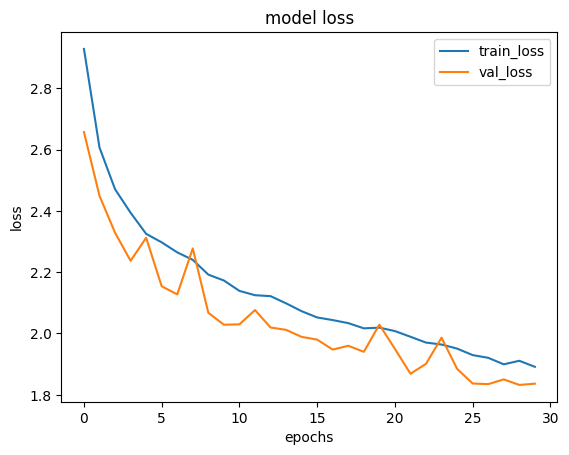

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])
plt.show()

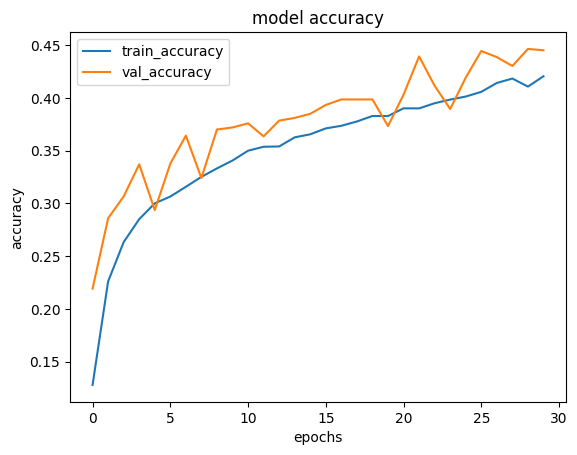

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()